In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/process_data.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

2023-12-06 16:26:24.737461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 16:26:24.741953: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 16:26:24.794665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:26:24.794714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:26:24.795728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
X.shape


(4452, 784, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [11]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import concatenate

# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')
import tensorflow
tensorflow.config.run_functions_eagerly(True)

no_classes = len(df['fault'].unique())
#head 1
inputs1 = Input(shape=(X.shape[1],X.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(X.shape[1],X.shape[2]))
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(X.shape[1],X.shape[2]))
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

# Plot Model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 784, 1)]             0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 784, 1)]             0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 784, 1)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 585, 64)              12864     ['input_4[0][0]']             
                                                                                            

In [7]:
batch_size =100
epochs = 5
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)


Epoch 1/5


/home/raj/.local/share/virtualenvs/stm32-YMZVAU0V/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 11s 343ms/step - loss: 1.9578 - accuracy: 0.3424 - val_loss: 1.3322 - val_accuracy: 0.5928
Epoch 2/5
32/32 [==============================] - 11s 331ms/step - loss: 0.7822 - accuracy: 0.7927 - val_loss: 0.5562 - val_accuracy: 0.9753
Epoch 3/5
32/32 [==============================] - 11s 357ms/step - loss: 0.1546 - accuracy: 0.9766 - val_loss: 0.1775 - val_accuracy: 0.9858
Epoch 4/5
32/32 [==============================] - 11s 354ms/step - loss: 0.0525 - accuracy: 0.9872 - val_loss: 0.1053 - val_accuracy: 0.9918
Epoch 5/5
32/32 [==============================] - 14s 427ms/step - loss: 0.0250 - accuracy: 0.9961 - val_loss: 0.0790 - val_accuracy: 0.9985


42/42 [==============================] - 1s 21ms/step


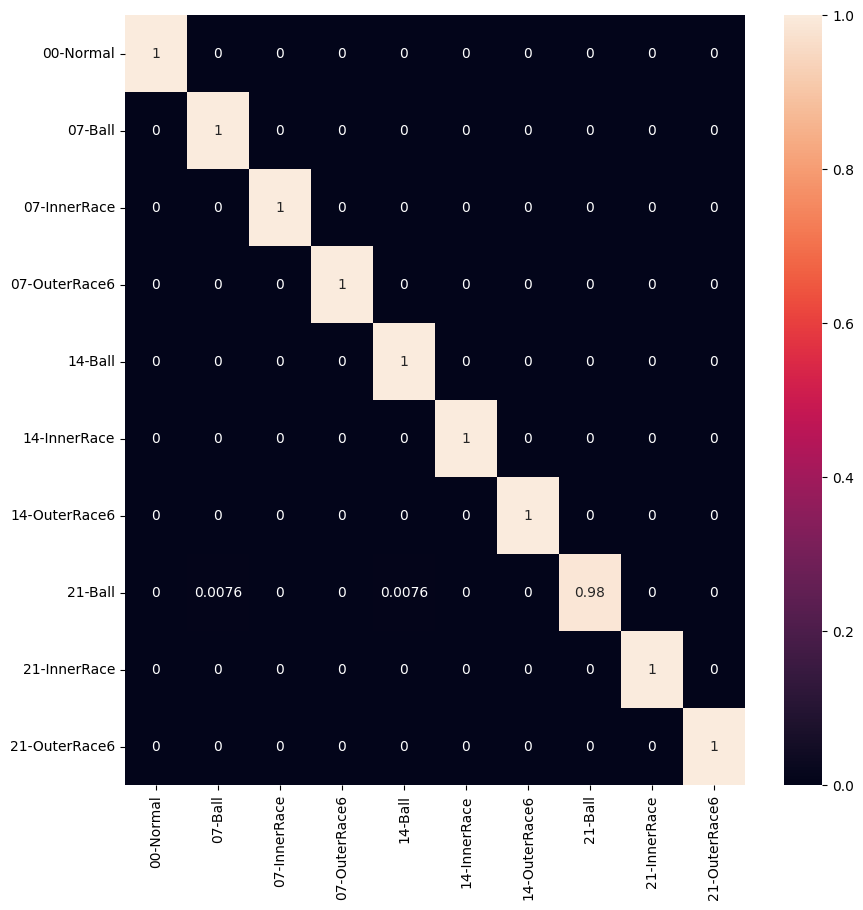

In [8]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [9]:

dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])
y_viz.shape


 7/98 [=>............................] - ETA: 1s

/home/raj/.local/share/virtualenvs/stm32-YMZVAU0V/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


98/98 [==============================] - 3s 26ms/step


(3116, 100)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3116 samples in 0.000s...
[t-SNE] Computed neighbors for 3116 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3116
[t-SNE] Computed conditional probabilities for sample 2000 / 3116
[t-SNE] Computed conditional probabilities for sample 3000 / 3116
[t-SNE] Computed conditional probabilities for sample 3116 / 3116
[t-SNE] Mean sigma: 0.557449
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.828575
[t-SNE] KL divergence after 300 iterations: 1.332929


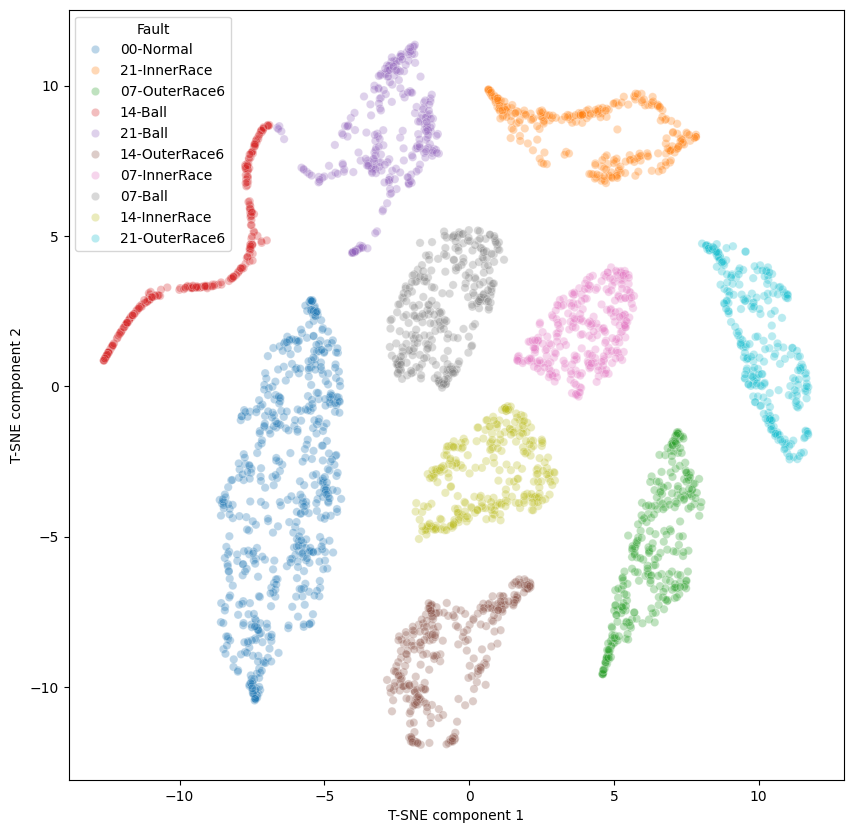

In [10]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()